<a href="https://colab.research.google.com/github/Bareera2505/Deep-Learning-Labs/blob/main/Lab9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import torch
from torch import nn
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import uuid

In [2]:
# Configurable variables
NUM_EPOCHS = 5
NOISE_DIMENSION = 50
BATCH_SIZE = 128
TRAIN_ON_GPU = True
UNIQUE_RUN_ID = str(uuid.uuid4())
PRINT_STATS_AFTER_BATCH = 150
OPTIMIZER_LR = 0.0002
OPTIMIZER_BETAS = (0.5, 0.999)

In [3]:
# Speed ups
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
torch.backends.cudnn.benchmark = True


In [4]:
class Generator(nn.Module):
  """
    DCGan Generator
  """
  def __init__(self,):
    super().__init__()
    num_feature_maps = 64
    self.layers = nn.Sequential(
      # First upsampling block
      nn.ConvTranspose2d(NOISE_DIMENSION, num_feature_maps * 8, 4, 1, 0, bias=False),
      nn.BatchNorm2d(num_feature_maps * 8),
      nn.ReLU(),
      # Second upsampling block
      nn.ConvTranspose2d(num_feature_maps * 8, num_feature_maps * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(num_feature_maps * 4),
      nn.ReLU(),
      # Third upsampling block
      nn.ConvTranspose2d(num_feature_maps * 4, num_feature_maps * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(num_feature_maps * 2),
      nn.ReLU(),
      # Fourth upsampling block
      nn.ConvTranspose2d(num_feature_maps * 2, num_feature_maps, 4, 2, 1, bias=False),
      nn.BatchNorm2d(num_feature_maps),
      nn.ReLU(),
      # Fifth upsampling block: note Tanh
      nn.ConvTranspose2d(num_feature_maps, 1, 1, 1, 2, bias=False),
      nn.Tanh()
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)

In [5]:
class Discriminator(nn.Module):
  """
    DCGan Discriminator
  """
  def __init__(self):
    super().__init__()
    num_feature_maps = 64
    self.layers = nn.Sequential(
      nn.Conv2d(1, num_feature_maps, 4, 2, 1, bias=False),
      nn.BatchNorm2d(num_feature_maps * 1),
      nn.LeakyReLU(0.2),
      nn.Conv2d(num_feature_maps, num_feature_maps * 2, 4, 2, 1, bias=False),
      nn.BatchNorm2d(num_feature_maps * 2),
      nn.LeakyReLU(0.2),
      nn.Conv2d(num_feature_maps * 2, num_feature_maps * 4, 4, 2, 1, bias=False),
      nn.BatchNorm2d(num_feature_maps * 4),
      nn.LeakyReLU(0.2),
      nn.Conv2d(num_feature_maps * 4, 1, 4, 2, 1, bias=False),
      nn.Flatten(),
      nn.Linear(1, 1),
      nn.Sigmoid()
    )

  def forward(self, x):
    """Forward pass"""
    return self.layers(x)

In [6]:
def get_device():
  """ Retrieve device based on settings and availability. """
  return torch.device("cuda:0" if torch.cuda.is_available() and TRAIN_ON_GPU else "cpu")
    

In [7]:
def make_directory_for_run():
  """ Make a directory for this training run. """
  print(f'Preparing training run {UNIQUE_RUN_ID}')
  if not os.path.exists('./runs'):
    os.mkdir('./runs')
  os.mkdir(f'./runs/{UNIQUE_RUN_ID}')



In [8]:
def generate_image(generator, epoch = 0, batch = 0, device=get_device()):
  """ Generate subplots with generated examples. """
  images = []
  noise = generate_noise(BATCH_SIZE, device=device)
  generator.eval()
  images = generator(noise)
  plt.figure(figsize=(10, 10))
  for i in range(16):
    # Get image
    image = images[i]
    # Convert image back onto CPU and reshape
    image = image.cpu().detach().numpy()
    image = np.reshape(image, (28, 28))
    # Plot
    plt.subplot(4, 4, i+1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
  if not os.path.exists(f'./runs/{UNIQUE_RUN_ID}/images'):
    os.mkdir(f'./runs/{UNIQUE_RUN_ID}/images')
  plt.savefig(f'./runs/{UNIQUE_RUN_ID}/images/epoch{epoch}_batch{batch}.jpg')


In [9]:
def save_models(generator, discriminator, epoch):
  """ Save models at specific point in time. """
  torch.save(generator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/generator_{epoch}.pth')
  torch.save(discriminator.state_dict(), f'./runs/{UNIQUE_RUN_ID}/discriminator_{epoch}.pth')


def print_training_progress(batch, generator_loss, discriminator_loss):
  """ Print training progress. """
  print('Losses after mini-batch %5d: generator %e, discriminator %e' %
        (batch, generator_loss, discriminator_loss))



In [10]:
def prepare_dataset():
  """ Prepare dataset through DataLoader """
  # Prepare MNIST dataset
  dataset = MNIST(os.getcwd(), download=True, train=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
  ]))
  # Batch and shuffle data with DataLoader
  trainloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
  # Return dataset through DataLoader
  return trainloader
    

In [11]:
def weights_init(m):
  """ Normal weight initialization as suggested for DCGANs """
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
      nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
      nn.init.normal_(m.weight.data, 1.0, 0.02)
      nn.init.constant_(m.bias.data, 0)


In [12]:
def initialize_models(device = get_device()):
  """ Initialize Generator and Discriminator models """
  generator = Generator()
  discriminator = Discriminator()
  # Perform proper weight initialization
  generator.apply(weights_init)
  discriminator.apply(weights_init)
  # Move models to specific device
  generator.to(device)
  discriminator.to(device)
  # Return models
  return generator, discriminator


In [13]:
def initialize_loss():
  """ Initialize loss function. """
  return nn.BCELoss()


def initialize_optimizers(generator, discriminator):
  """ Initialize optimizers for Generator and Discriminator. """
  generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=OPTIMIZER_LR,betas=OPTIMIZER_BETAS)
  return generator_optimizer, discriminator_optimizer
  

def generate_noise(number_of_images = 1, noise_dimension = NOISE_DIMENSION, device=None):
  """ Generate noise for number_of_images images, with a specific noise_dimension """
  return torch.randn(number_of_images, noise_dimension, 1, 1, device=device)


def efficient_zero_grad(model):
  """ 
    Apply zero_grad more efficiently
    Source: https://betterprogramming.pub/how-to-make-your-pytorch-code-run-faster-93079f3c1f7b
  """
  for param in model.parameters():
    param.grad = None


def forward_and_backward(model, data, loss_function, targets):
  """
    Perform forward and backward pass in a generic way. Returns loss value.
  """
  outputs = model(data)
  error = loss_function(outputs, targets)
  error.backward()
  return error.item()




In [14]:
 def perform_train_step(generator, discriminator, real_data, \
  loss_function, generator_optimizer, discriminator_optimizer, device = get_device()):
  """ Perform a single training step. """
  
  # 1. PREPARATION
  # Set real and fake labels.
  real_label, fake_label = 1.0, 0.0
  # Get images on CPU or GPU as configured and available
  # Also set 'actual batch size', whih can be smaller than BATCH_SIZE
  # in some cases.
  real_images = real_data[0].to(device)
  actual_batch_size = real_images.size(0)
  label = torch.full((actual_batch_size,1), real_label, device=device)
  
  # 2. TRAINING THE DISCRIMINATOR
  # Zero the gradients for discriminator
  efficient_zero_grad(discriminator)
  # Forward + backward on real iamges
  error_real_images = forward_and_backward(discriminator, real_images, \
    loss_function, label)
  # Forward + backward on generated images
  noise = generate_noise(actual_batch_size, device=device)
  generated_images = generator(noise)
  label.fill_(fake_label)
  error_generated_images =forward_and_backward(discriminator, \
    generated_images.detach(), loss_function, label)
  # Optim for discriminator
  discriminator_optimizer.step()
  
  # 3. TRAINING THE GENERATOR
  # Forward + backward + optim for generator, including zero grad
  efficient_zero_grad(generator)
  label.fill_(real_label)
  error_generator = forward_and_backward(discriminator, generated_images, loss_function, label)
  generator_optimizer.step()
  
  # 4. COMPUTING RESULTS
  # Compute loss values in floats for discriminator, which is joint loss.
  error_discriminator = error_real_images + error_generated_images
  # Return generator and discriminator loss so that it can be printed.
  return error_generator, error_discriminator

In [15]:
def perform_epoch(dataloader, generator, discriminator, loss_function, \
    generator_optimizer, discriminator_optimizer, epoch):
  """ Perform a single epoch. """
  for batch_no, real_data in enumerate(dataloader, 0):
    # Perform training step
    generator_loss_val, discriminator_loss_val = perform_train_step(generator, \
      discriminator, real_data, loss_function, \
      generator_optimizer, discriminator_optimizer)
    # Print statistics and generate image after every n-th batch
    if batch_no % PRINT_STATS_AFTER_BATCH == 0:
      print_training_progress(batch_no, generator_loss_val, discriminator_loss_val)
      generate_image(generator, epoch, batch_no)
  # Save models on epoch completion.
  save_models(generator, discriminator, epoch)
  # Clear memory after every epoch
  torch.cuda.empty_cache()

In [16]:
def train_dcgan():
  """ Train the DCGAN. """
  # Make directory for unique run
  make_directory_for_run()
  # Set fixed random number seed
  torch.manual_seed(42)
  # Get prepared dataset
  dataloader = prepare_dataset()
  # Initialize models
  generator, discriminator = initialize_models()
  # Initialize loss and optimizers
  loss_function = initialize_loss()
  generator_optimizer, discriminator_optimizer = initialize_optimizers(generator, discriminator)
  # Train the model
  for epoch in range(NUM_EPOCHS):
    print(f'Starting epoch {epoch}...')
    perform_epoch(dataloader, generator, discriminator, loss_function, \
      generator_optimizer, discriminator_optimizer, epoch)
  # Finished :-)
  print(f'Finished unique run {UNIQUE_RUN_ID}')

Preparing training run f90bd7eb-8e45-4d24-8a55-90ed0c1f4ac9


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw

Starting epoch 0...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Losses after mini-batch     0: generator 1.357544e+00, discriminator 1.705213e+00
Losses after mini-batch   150: generator 5.314479e+00, discriminator 1.617540e-02
Losses after mini-batch   300: generator 6.001054e+00, discriminator 6.248754e-03
Losses after mini-batch   450: generator 6.000543e+00, discriminator 1.335706e-01
Starting epoch 1...
Losses after mini-batch     0: generator 3.597222e+00, discriminator 1.091209e-01
Losses after mini-batch   150: generator 5.055603e+00, discriminator 1.501681e-01
Losses after mini-batch   300: generator 7.538738e+00, discriminator 7.974318e-01
Losses after mini-batch   450: generator 3.435565e+00, discriminator 2.972361e-01
Starting epoch 2...
Losses after mini-batch     0: generator 3.214731e+00, discriminator 2.787696e-01
Losses after mini-batch   150: generator 3.018991e+00, discriminator 4.348346e-01
Losses after mini-batch   300: generator 1.777127e+00, discriminator 5.789541e-01
Losses after mini-batch   450: generator 1.886337e+00, dis

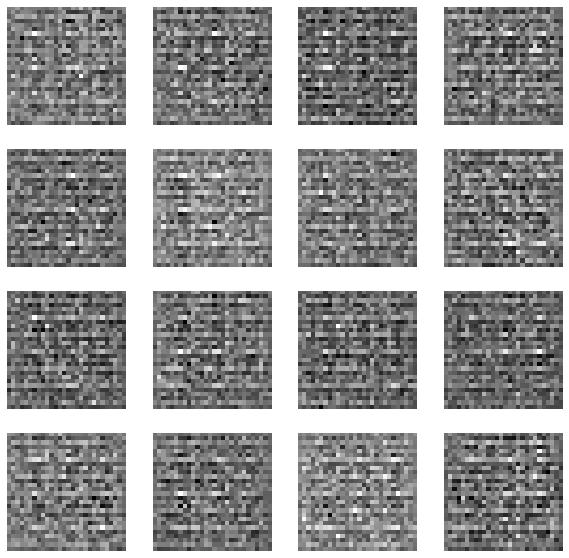

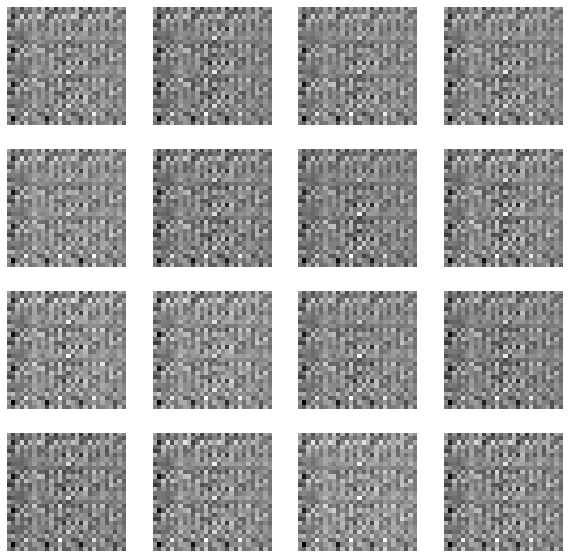

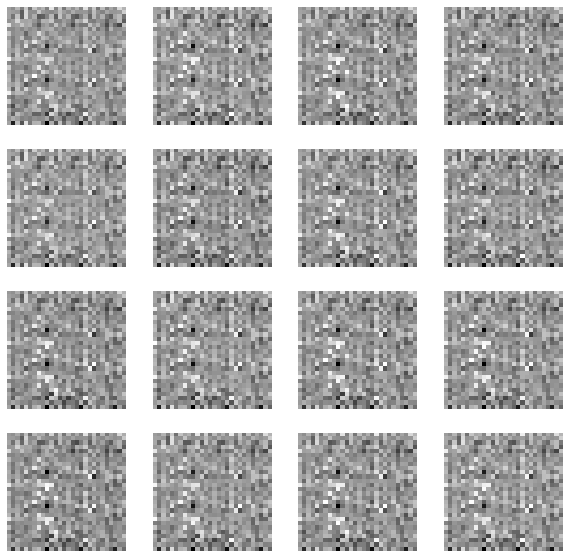

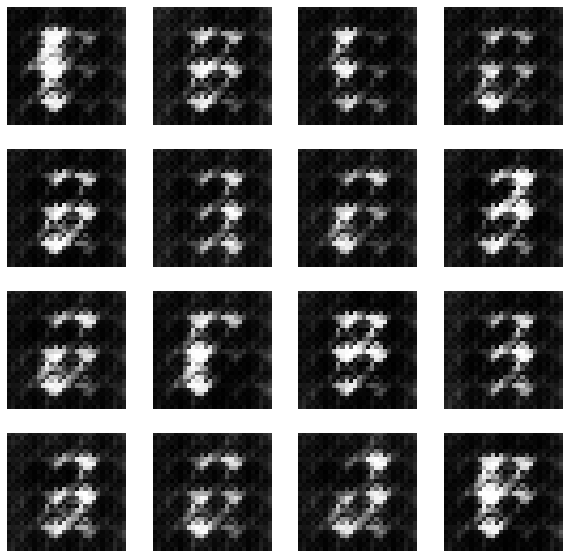

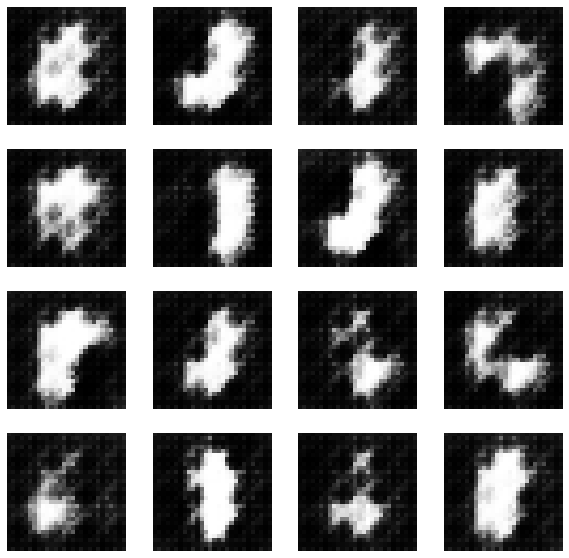

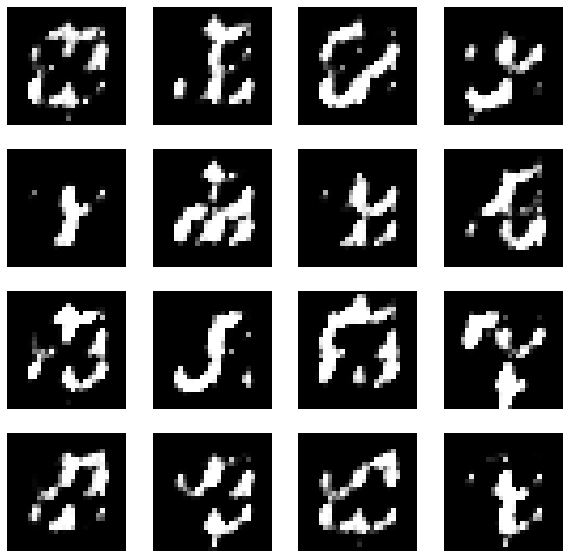

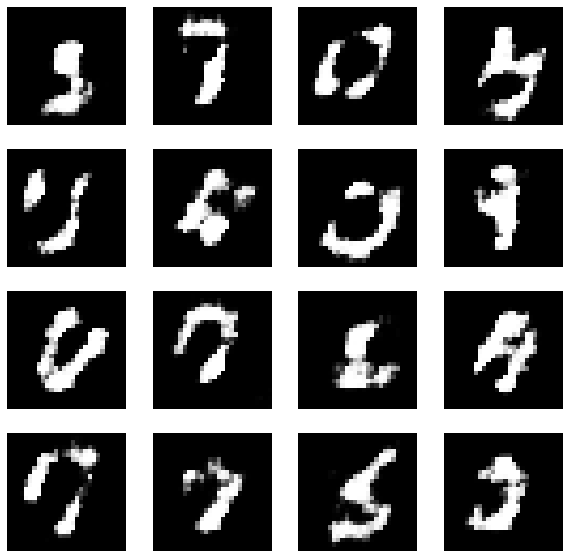

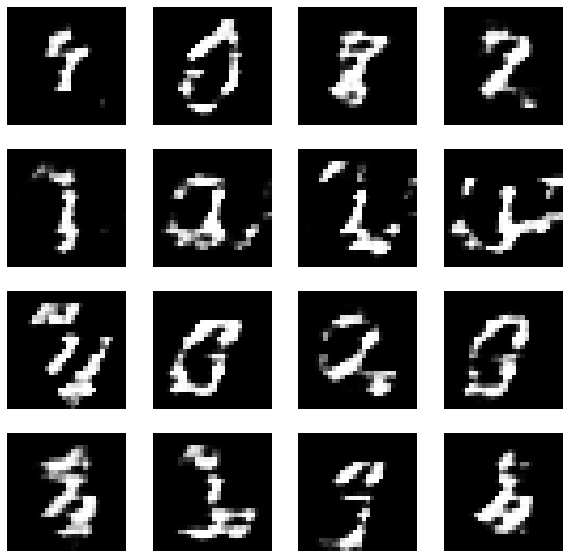

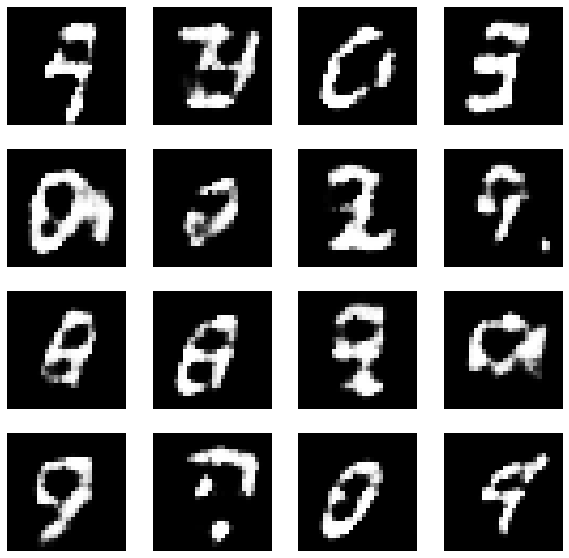

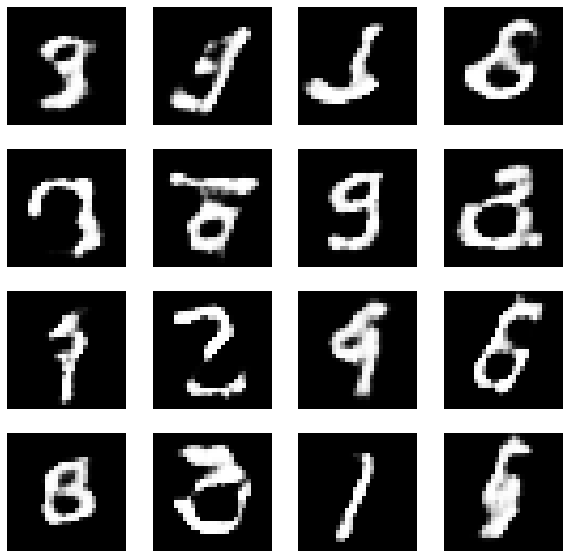

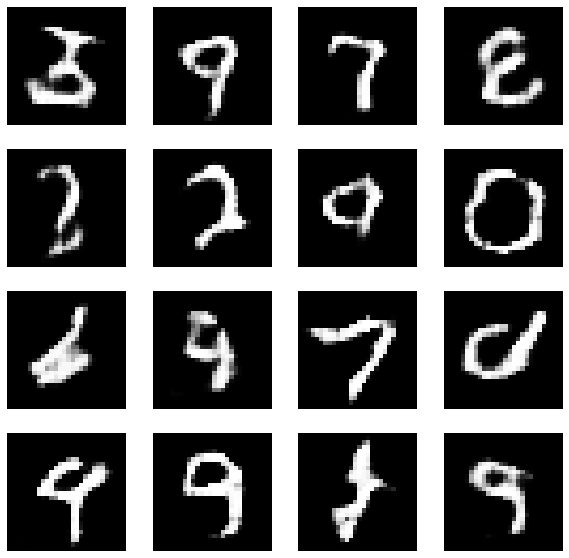

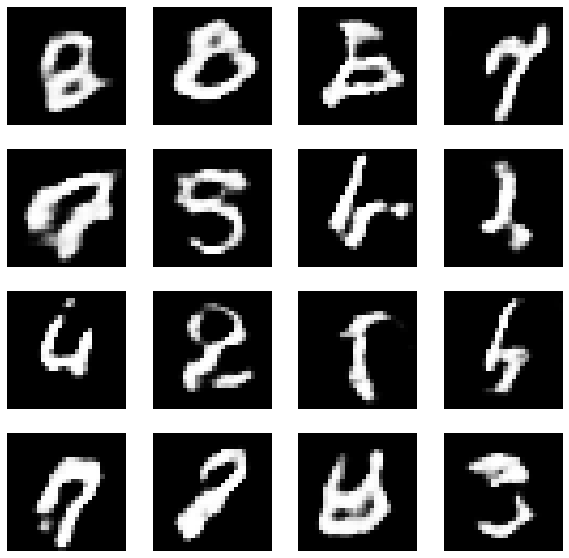

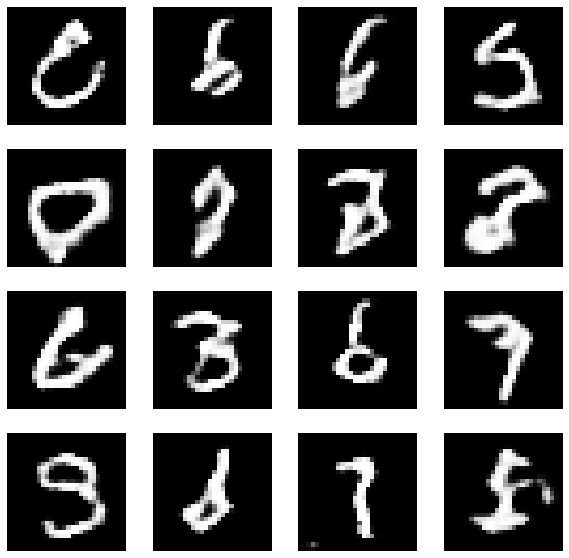

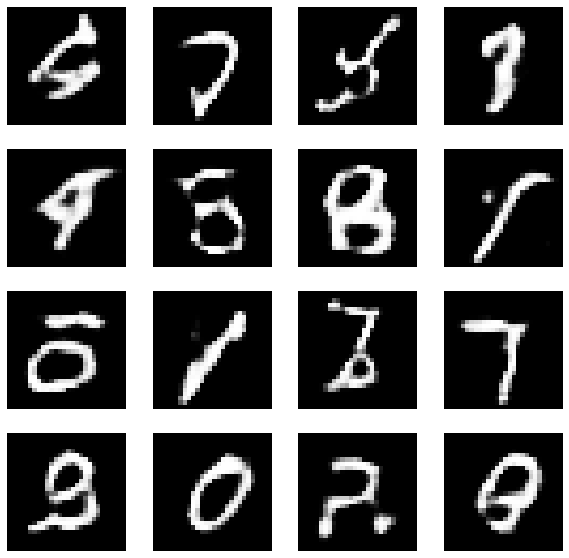

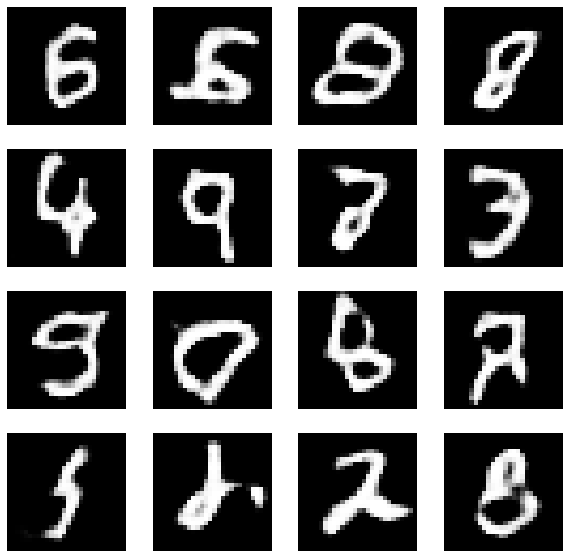

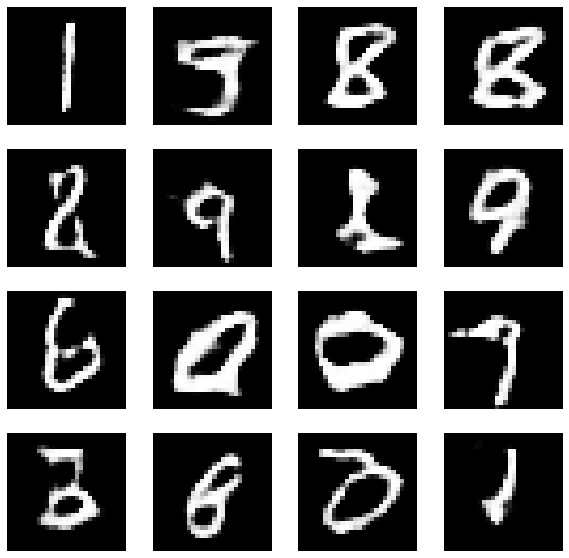

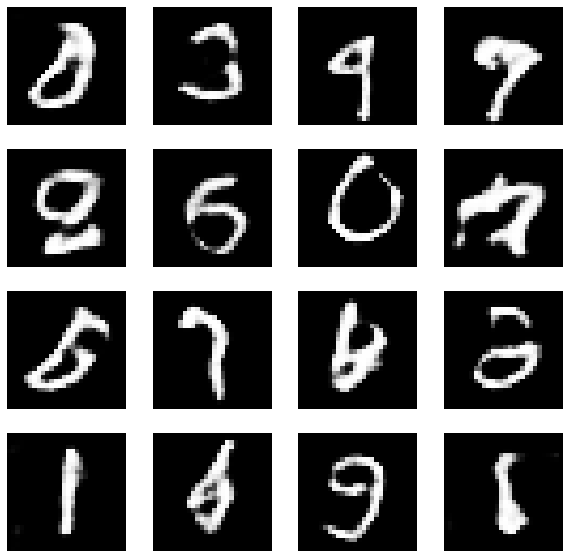

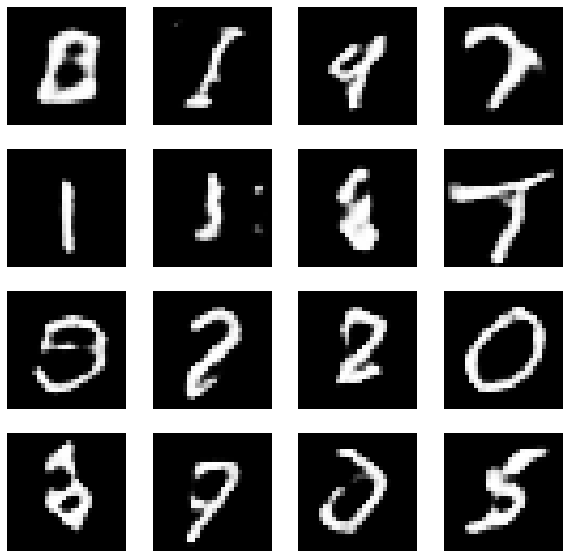

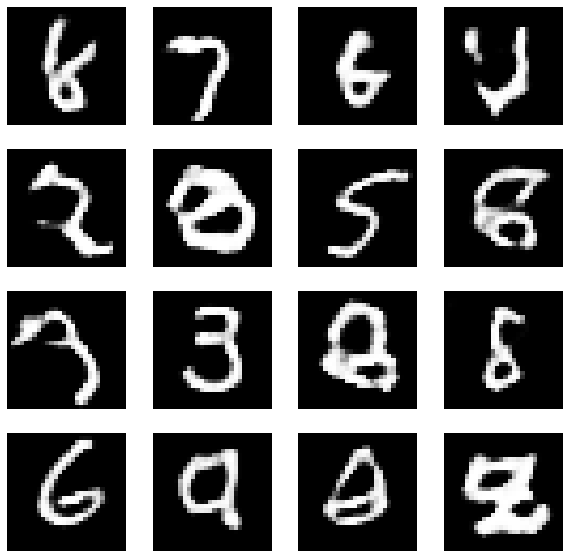

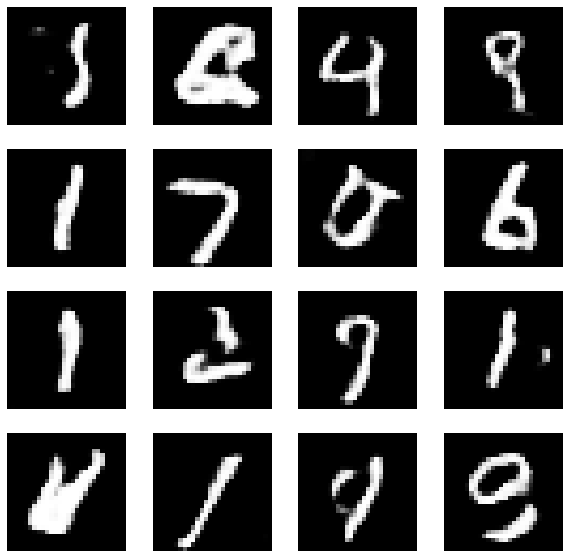

In [17]:
if __name__ == '__main__':
  train_dcgan()